In [1]:
import extract_features
import preprocessing
import utils

import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from itertools import product
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
def plot_confusion_matrix(cm, n_classes,display_labels):
    
    fig, ax = plt.subplots(figsize=(10,10))
    cm = cm
    
    im_ = ax.imshow(cm, interpolation='nearest', cmap='viridis')
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)
    
    text_ = np.empty_like(cm, dtype=object)
    values_format = '.2g'

    # print text with appropriate color depending on background
    thresh = (cm.max() - cm.min()) / 2.
    for i, j in product(range(n_classes), range(n_classes)):
        color = cmap_max if cm[i, j] < thresh else cmap_min
        text_[i, j] = ax.text(j, i,format(cm[i, j], values_format),
                                   ha="center", va="center",
                                   color=color)
        
    fig.colorbar(im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=display_labels,
           yticklabels=display_labels,
           ylabel="True label",
           xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation='vertical')

    figure_ = fig
    ax_ = ax

In [3]:
def plot_metric(valores, metrica, n_groups=10,):
    
    fig, ax = plt.subplots(figsize=(11,5))
    index = np.arange(n_groups)
    bar_width = 0.8
    
    rects1 = plt.bar(index,valores,bar_width,facecolor='#9999ff',edgecolor='black',label=metrica,alpha= 0.6)

    plt.xlabel('Mejor modelo',fontsize=13)
    plt.ylabel(metrica,fontsize=13)
    plt.title('{} VS Tipos de comidas Clase'.format(metrica),fontsize=18)
    plt.xticks(index, ('SVM \n''1 tipo','MLP \n''3 tipos','SVM \n''5 tipos','SVM \n''7 tipos','MLP \n''9 tipos',
                       'SVM \n''11 tipos','SVM \n''13 tipos','MLP \n''15 tipos','MLP \n''17 tipos','MLP \n''19 tipos'))
    plt.legend()

    for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%a' % float(height) + "%", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [4]:
def plot_results(images,predictions, id_label_map,n_images):
    
    fig, axis = plt.subplots(n_images,6, figsize=(20,20))
    
    k = 0
    for i in range(n_images):
        for j in range(3):
                
            axis[i][(2*j)].imshow(cv2.cvtColor(images[k], cv2.COLOR_BGR2RGB))
            axis[i][(2*j)].axis('off')
            
            pred = id_label_map[int(predictions[k])]
            axis[i][(2*j)+1].text(0.5, 0.5, pred, size=25, ha="center", va="center",
                    bbox=dict(
                        boxstyle="round",
                        ec=(1., 0.5, 0.5),
                        fc=(1., 0.8, 0.8),
                    )
                   )
            axis[i][(2*j)+1].set_title('Prediction')
            axis[i][(2*j)+1].axis('off')
            
            k += 1
    plt.show()

In [5]:
def obtener_imagenes_predecir(image_to_predict_folder):
    image_list = list()
    image_texture_list = list()
    
    for image_path in os.listdir(image_to_predict_folder):
    
        image = cv2.imread(os.path.join(image_to_predict_folder,image_path))
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # extract haralick texture from the image
        textures = preprocessing.extract_features(gray)

        image_list.append(image)
        image_texture_list.append(textures)
    
    return image_list,image_texture_list

In [6]:
n_groups = 10
metricas = ['Accuracy','Precision','Recall','F1 Score']
valores = [[0.74,0.48,0.48,0.47,0.46,0.45,0.45,0.48,0.45,0.46],
           [0.74,0.48,0.48,0.47,0.46,0.45,0.46,0.48,0.45,0.46],
           [0.74,0.48,0.48,0.47,0.46,0.45,0.45,0.48,0.45,0.46],
           [0.74,0.48,0.48,0.47,0.45,0.45,0.45,0.48,0.45,0.46]]

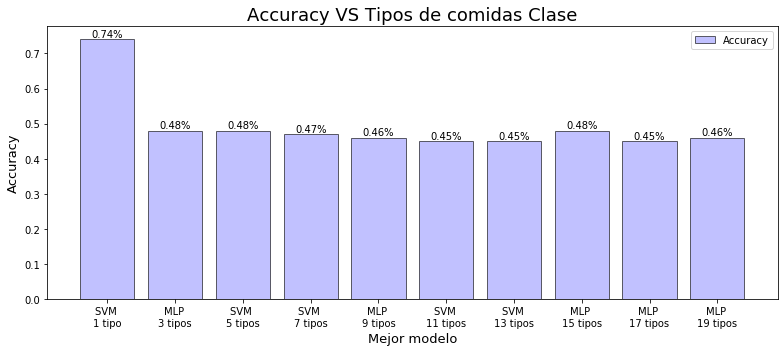

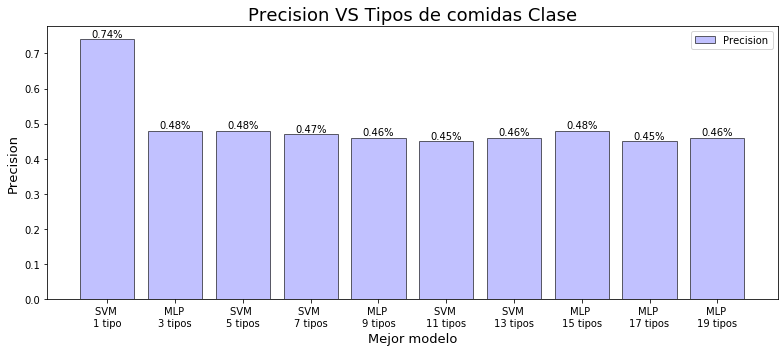

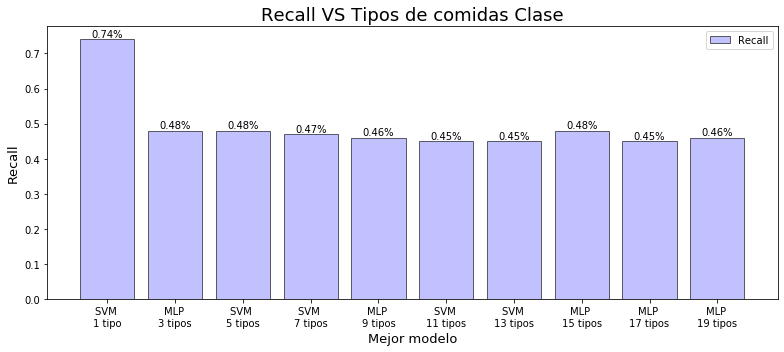

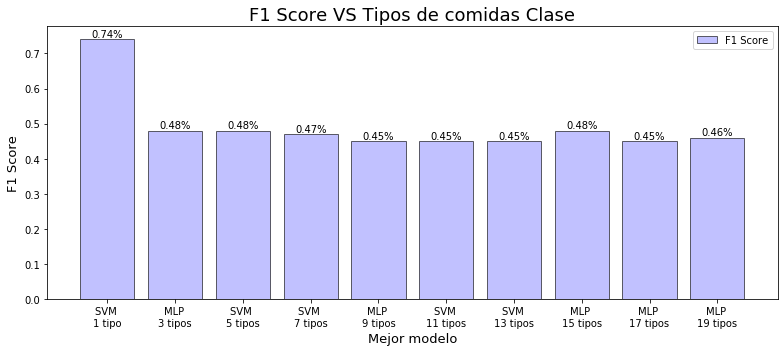

In [7]:
for i in range(len(metricas)):
    plot_metric(valores[i],metricas[i],n_groups)

# CONSTRUCCIÓN DE MODELOS Y PREDICCIONES

### OBTENER DATOS

In [8]:
full_data = extract_features.matriz_features('features-resultados-1')
X = full_data[:,:-1]
y = full_data[:,-1]

In [9]:
X.shape,y.shape

((3000, 26), (3000,))

### CONSTRUCCIÓN DEL MODELO

**ESCALAMIENTO DE LOS DATOS**

In [10]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train_scaled.shape, X_test.shape, y_train.shape, y_test.shape

((2700, 26), (300, 26), (2700,), (300,))

**ENTRENAMIENTO**

In [12]:
clasificador = SVC(C=1,decision_function_shape='ovr',kernel='linear')

t_beg = time.time()
clasificador.fit(X_train_scaled,y_train)
print('El tiempo de entrenamiento fue: {:0.3f}'.format(time.time() - t_beg))

El tiempo de entrenamiento fue: 0.328


**VERIFICACIÓN DE RESULTADOS**

In [13]:
y_true, y_pred = y_test, clasificador.predict(X_test_scaled)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels=['0','1','2'])

              precision    recall  f1-score   support

           0       0.72      0.74      0.73        96
           1       0.69      0.71      0.70        96
           2       0.85      0.81      0.83       108

    accuracy                           0.76       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.76      0.76       300



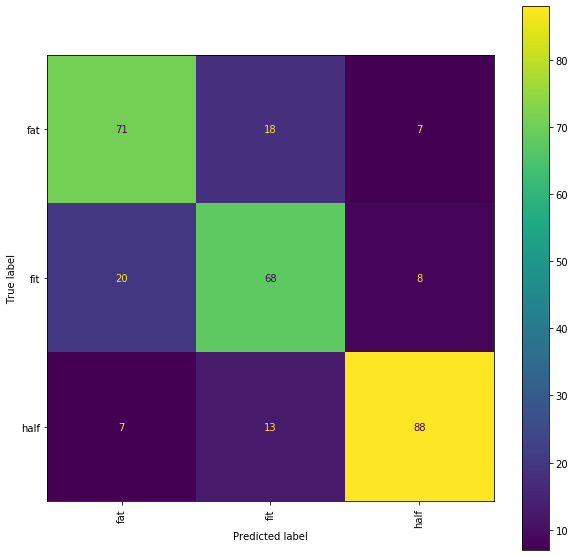

In [14]:
plot_confusion_matrix(cm, 3,['fat','fit','half'])

**GUARDAR EL MODELO**

In [15]:
model_path = 'checkpoints'
model_save_path = os.path.join(model_path,'fit-or-fat-1.joblib')

In [16]:
if not os.path.exists(os.path.join(model_path)):
    os.makedirs(os.path.join(model_path))
    
print(f"Saving model at {model_save_path}")   

with open(model_save_path, 'wb') as f:
    joblib.dump(clasificador, f)

Saving model at checkpoints\fit-or-fat-1.joblib


### PREDICCIONES

**Obtener imagenes para predecir y sus texturas**

In [17]:
image_list, image_texture_list = obtener_imagenes_predecir(os.path.join('dataset','data-to-predict-1'))

In [18]:
X_pred = np.asmatrix(image_texture_list)

**Escalar los datos**

In [19]:
scaler = StandardScaler()

X_pred_scaled = scaler.fit_transform(X_pred)

**Cargar el modelo**

In [20]:
with open(model_save_path, 'rb') as f:
    clasificador = joblib.load(f)

**Predecir**

In [21]:
predicciones = clasificador.predict(X_pred_scaled)

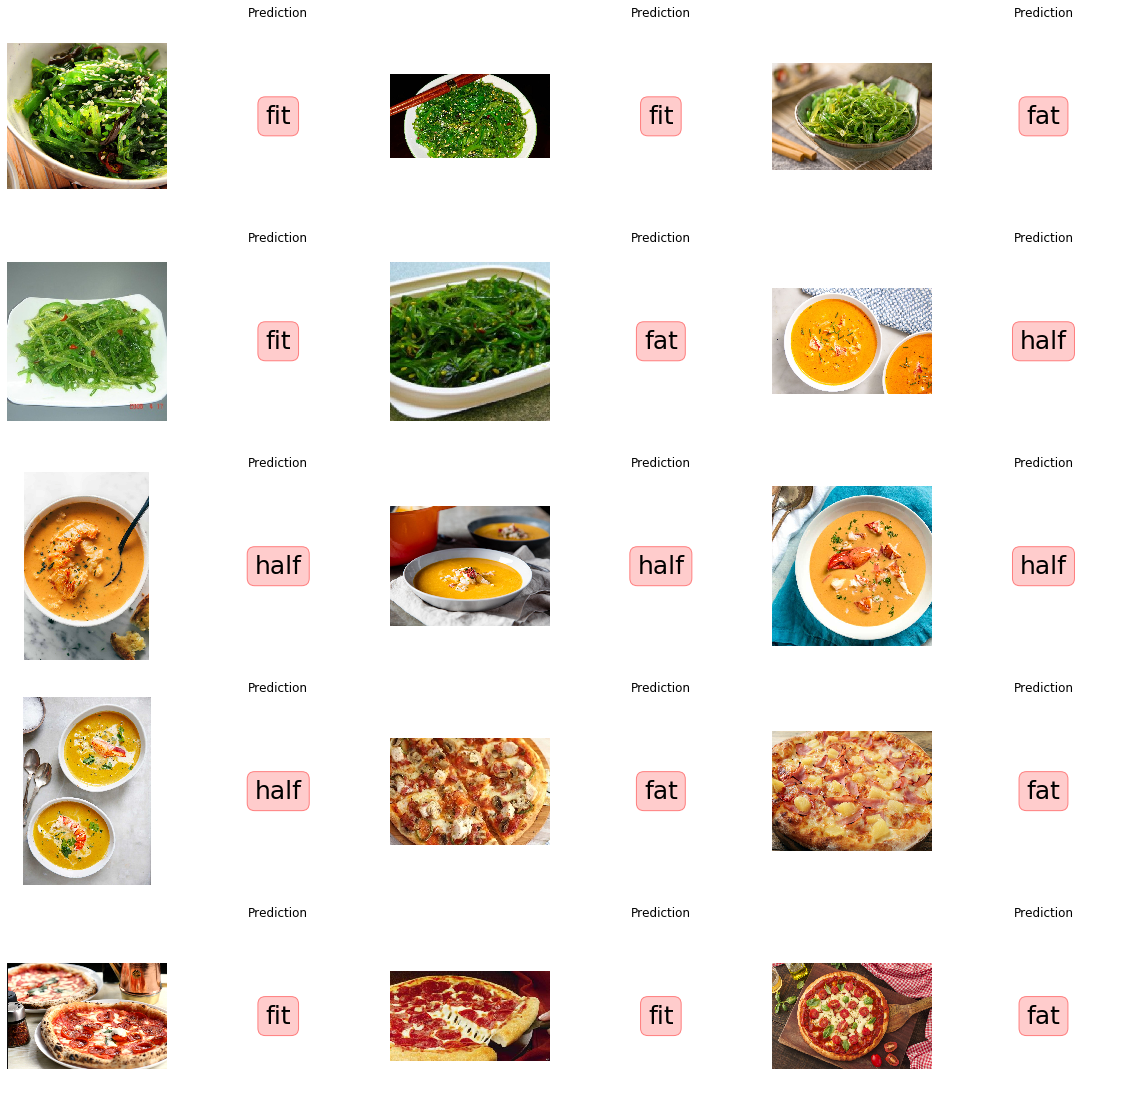

In [22]:
id_label_map, _ = utils.make_label_map(os.path.join('dataset','features'))
plot_results(image_list, predicciones, id_label_map,n_images=5)

## Ahora se realizaran los mismos pasos para con 11 tipos de comida

In [23]:
full_data = extract_features.matriz_features('features-resultados-11')
X = full_data[:,:-1]
y = full_data[:,-1]

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clasificador = SVC(C=10,decision_function_shape='ovr',kernel='rbf',gamma=0.01)

t_beg = time.time()
clasificador.fit(X_train_scaled,y_train)
print('El tiempo de entrenamiento fue: {:0.3f}'.format(time.time() - t_beg))

y_true, y_pred = y_test, clasificador.predict(X_test_scaled)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred, labels=['0','1','2'])

model_path = 'checkpoints'
model_save_path = os.path.join(model_path,'fit-or-fat-11.joblib')

if not os.path.exists(os.path.join(model_path)):
    os.makedirs(os.path.join(model_path))
    
print(f"Saving model at {model_save_path}")   

with open(model_save_path, 'wb') as f:
    joblib.dump(clasificador, f)

El tiempo de entrenamiento fue: 80.044
              precision    recall  f1-score   support

           0       0.47      0.38      0.42      1101
           1       0.47      0.40      0.43      1159
           2       0.43      0.58      0.50      1040

    accuracy                           0.45      3300
   macro avg       0.46      0.46      0.45      3300
weighted avg       0.46      0.45      0.45      3300

Saving model at checkpoints\fit-or-fat-11.joblib


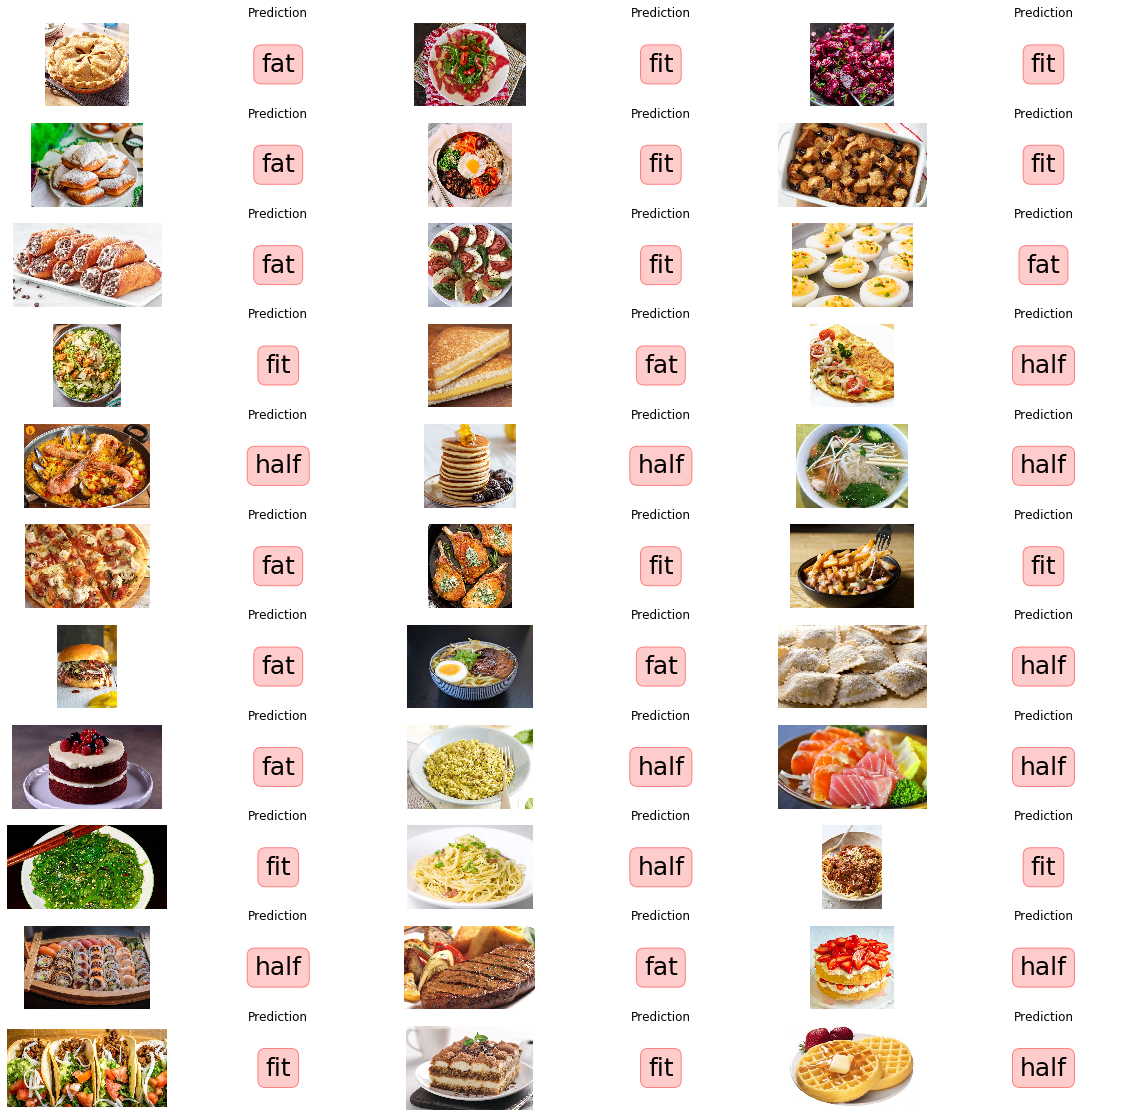

In [24]:
image_list, image_texture_list = obtener_imagenes_predecir(os.path.join('dataset','data-to-predict-11'))

X_pred = np.asmatrix(image_texture_list)

scaler = StandardScaler()
X_pred_scaled = scaler.fit_transform(X_pred)

with open(model_save_path, 'rb') as f:
    clasificador = joblib.load(f)
    
predicciones = clasificador.predict(X_pred_scaled)

id_label_map, _ = utils.make_label_map(os.path.join('dataset','features'))
plot_results(image_list, predicciones, id_label_map,n_images=11)